In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_y_exp
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_ei_basic
from bo_functions import eval_GP_basic_tot
from bo_functions import create_sse_data

from bo_plotters import plot_hyperparams
from bo_plotters import plot_xy
from bo_plotters import y_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0.1**2
q = 2

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])
# print(train_sse)

In [4]:
#Reduce Number of Training Points
t =len(train_T) #Desired number of training points
t = 3 #Set t=5 to show changing EI
train_T = train_T[0:t]
train_sse = train_sse[0:t]

In [5]:
#Define GP Testing space
#Define Testing Space
p=10
# Theta1 =  np.linspace(0,2,p) #1x10
# Theta2 =  np.linspace(-2,0,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(theta_mesh)

Point [[-2. -2.]]
Model Mean 54.6384291253881
Model Var 0.5529694830376142
Point [[-1.55555556 -2.        ]]
Model Mean 58.937248949959674
Model Var 0.421891985867367
Point [[-1.11111111 -2.        ]]
Model Mean 54.35992715940125
Model Var 0.532398227049325
Point [[-0.66666667 -2.        ]]
Model Mean 42.52070847524047
Model Var 0.7677358012986171
Point [[-0.22222222 -2.        ]]
Model Mean 27.897573770500635
Model Var 0.9121647860760633
Point [[ 0.22222222 -2.        ]]
Model Mean 14.814546909775341
Model Var 0.8677122881214872
Point [[ 0.66666667 -2.        ]]
Model Mean 5.816385179526073
Model Var 0.6984595820964196
Point [[ 1.11111111 -2.        ]]
Model Mean 1.7571286537805442
Model Var 0.5788124666471943
Point [[ 1.55555556 -2.        ]]
Model Mean 2.135332427967265
Model Var 0.6404557603896625
Point [[ 2. -2.]]
Model Mean 5.288525906450198
Model Var 0.8270287227905517
Point [[-2.         -1.55555556]]
Model Mean 60.72894156571996
Model Var 0.3737430060244946
Point [[-1.55555556

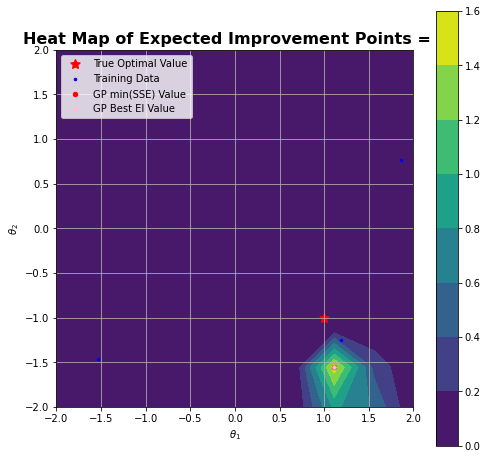

Point [[-2. -2.]]
Model Mean 54.46349651535433
Model Var 0.552924990542357
Point [[-1.55555556 -2.        ]]
Model Mean 59.01765736608887
Model Var 0.4218491101715435
Point [[-1.11111111 -2.        ]]
Model Mean 55.13410443483366
Model Var 0.5303566534888228
Point [[-0.66666667 -2.        ]]
Model Mean 44.697752050561746
Model Var 0.752446659699589
Point [[-0.22222222 -2.        ]]
Model Mean 32.23649505542103
Model Var 0.8527520231333047
Point [[ 0.22222222 -2.        ]]
Model Mean 21.590328941598464
Model Var 0.724685616006225
Point [[ 0.66666667 -2.        ]]
Model Mean 14.311653499383493
Model Var 0.4752321417806238
Point [[ 1.11111111 -2.        ]]
Model Mean 10.358716375677997
Model Var 0.3503569068587332
Point [[ 1.55555556 -2.        ]]
Model Mean 9.162154409781671
Model Var 0.4871191155213226
Point [[ 2. -2.]]
Model Mean 9.891242976067215
Model Var 0.7598558984479645
Point [[-2.         -1.55555556]]
Model Mean 60.5271819440613
Model Var 0.37365856042053347
Point [[-1.55555556

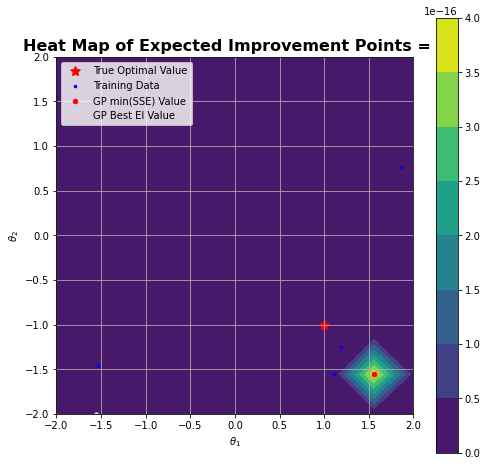

Point [[-2. -2.]]
Model Mean 82.48171396152415
Model Var 0.34381455171042496
Point [[-1.55555556 -2.        ]]
Model Mean 89.35997016005541
Model Var 0.17629483245164634
Point [[-1.11111111 -2.        ]]
Model Mean 82.10130776124197
Model Var 0.3365080202086863
Point [[-0.66666667 -2.        ]]
Model Mean 64.34662975707644
Model Var 0.6497933617233079
Point [[-0.22222222 -2.        ]]
Model Mean 43.938644652935224
Model Var 0.8165250598647443
Point [[ 0.22222222 -2.        ]]
Model Mean 27.234403521698308
Model Var 0.7163334056302406
Point [[ 0.66666667 -2.        ]]
Model Mean 16.454179786161138
Model Var 0.4740505369093825
Point [[ 1.11111111 -2.        ]]
Model Mean 10.944966950551574
Model Var 0.35027530832931
Point [[ 1.55555556 -2.        ]]
Model Mean 9.24978141787015
Model Var 0.4871186581200765
Point [[ 2. -2.]]
Model Mean 9.910530010360679
Model Var 0.7598550655404361
Point [[-2.         -1.55555556]]
Model Mean 71.7762965224596
Model Var 0.3400274738296829
Point [[-1.5555555

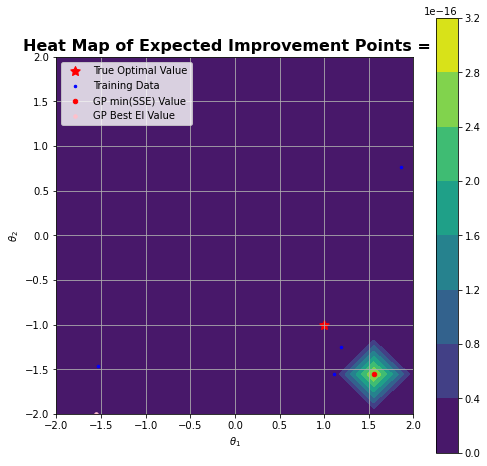

In [6]:
#Training the GP Model
iterations = 300
explore_bias = 0
verbose = True

BO_iter = 3

train_T_dict = {}
train_sse_dict = {}
ei_dict = {}
sse_dict ={}
var_dict ={}
GP_mean_best_dict = {}
GP_var_best_dict = {}
GP_mean_min_dict ={}
GP_var_min_dict = {}
Theta_Opt_dict = {}
Theta_Best_dict = {}
Best_Error_dict = {}
if verbose == True:
    z_dict = {}
    ei_term_1_dict = {}
    ei_term_2_dict = {}
    CDF_dict = {}
    PDF_dict = {}

for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    
    train_T_dict[i+1] = train_T
    train_sse_dict[i+1] = train_sse
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    
    ##Set Hyperparameters to 1
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    #Same point keeps being selected, should I remove that point by force?
    ei_components = eval_GP_basic_tot(p,theta_mesh, train_sse, model, likelihood, explore_bias, verbose)
    ei = ei_components[0]
    sse = ei_components[1]
    var = ei_components[2]
    stdev = ei_components[3]
    best_error = ei_components[4]
    if verbose == True:
        z = ei_components[5]
        ei_term_1 = ei_components[6]
        ei_term_2 = ei_components[7]
        CDF = ei_components[8]
        PDF = ei_components[9]
    
    ei_dict[i+1] = ei
    sse_dict[i+1] = sse
    var_dict[i+1] = var
    z_dict[i+1]=z
    Best_Error_dict[i+1] = best_error
    ei_term_1_dict[i+1] = ei_term_1
    ei_term_2_dict[i+1] = ei_term_2
    CDF_dict[i+1] = CDF
    PDF_dict[i+1] = PDF

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
    
    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=1e-10)==True))
#     print(argmax)
    if len(argmax[0]) != 1:
        argmax = np.array([[argmax[0,1]],[argmax[1,1]]])
        
        
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))    
    
    Theta_Opt_dict[i+1] = Theta_Opt_GP
    Theta_Best_dict[i+1] = Theta_Best

    GP_mean_min = sse[argmin[0],argmin[1]]
    GP_var_min = (stdev[argmin[0],argmin[1]])**2
    GP_mean_best = sse[argmax[0],argmax[1]]
    GP_var_best = (stdev[argmax[0],argmax[1]])**2
    
    GP_mean_best_dict[i+1] = GP_mean_best
    GP_var_best_dict[i+1] = GP_var_best
    GP_mean_min_dict[i+1] = GP_mean_min
    GP_var_min_dict[i+1] = GP_var_min
    
    ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP, Theta_Best,train_T,plot_train=True)
    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_T = train_T.numpy() #(q x t)
    train_sse = train_sse.numpy() #(1 x t)

    #Call the expensive function and evaluate at Theta_Best
    sse_Best = create_sse_data(q,Theta_Best, Xexp, Yexp) #(1 x 1)
 
    #Add Theta_Best to train_p and y_best to train_y
    train_T = np.concatenate((train_T, [Theta_Best]), axis=0) #(q x t)
    train_sse = np.concatenate((train_sse, [sse_Best]),axis=0) #(1 x t)
    


In [7]:
print(train_T_dict)
print(train_sse_dict)

#This is Expected

{1: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549]], dtype=torch.float64), 2: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556]], dtype=torch.float64), 3: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.1111, -1.5556],
        [-1.5556, -2.0000]], dtype=torch.float64)}
{1: tensor([113.8602,  71.0599,   2.5477], dtype=torch.float64), 2: tensor([113.8602,  71.0599,   2.5477,  10.5051], dtype=torch.float64), 3: tensor([113.8602,  71.0599,   2.5477,  10.5051,  98.7766], dtype=torch.float64)}


In [8]:
print("Max EIs")
print(np.amax(ei_dict[1]))
print(np.amax(ei_dict[2]))
print(np.amax(ei_dict[3]))

#EIs are expected

print("\nMin SSEs")
print(np.amin(sse_dict[1]))
print(np.amin(sse_dict[2]))
print(np.amin(sse_dict[3]))

##These are expected

print("\nBest EI GP Mean/Var")
print(GP_mean_best_dict)
print(GP_var_best_dict)

#GP Mean and EI Best vs Opt is the same. What does this mean?

print("\nLowest SSE GP Mean/Var")
print(GP_mean_min_dict)
print(GP_var_min_dict)

#Expected based on results above

print("\nTheta @ Lowest SSE")
print(Theta_Opt_dict)

#Expected based on results above
print("\nTheta @ Highest EI")
print(Theta_Best_dict)


print("z values")
print(z_dict[1],"\n", z_dict[2],"\n",z_dict[3])


print("Term 1 values")
print(ei_term_1_dict[1],"\n", ei_term_1_dict[2],"\n",ei_term_1_dict[3])

print("Term 2 values")
print(ei_term_2_dict[1],"\n", ei_term_2_dict[2],"\n",ei_term_2_dict[3])

print("CDF")
print(CDF[1],"\n", CDF[2],"\n",CDF[3])

print("PDF")
print(PDF[1],"\n", PDF[2],"\n",PDF[3])

Max EIs
1.4949674588160426
3.8476400140064584e-16
2.900080133220397e-16

Min SSEs
1.0530543802246832
6.844948839740535
6.864625362088486

Best EI GP Mean/Var
{1: array([1.05305438]), 2: array([59.01765737]), 3: array([89.35997016])}
{1: array([0.27353326]), 2: array([0.42184911]), 3: array([0.17629483])}

Lowest SSE GP Mean/Var
{1: array([1.05305438]), 2: array([6.84494884]), 3: array([6.86462536])}
{1: array([0.27353326]), 2: array([0.30930648]), 3: array([0.30930647])}

Theta @ Lowest SSE
{1: array([ 1.11111111, -1.55555556]), 2: array([ 1.55555556, -1.55555556]), 3: array([ 1.55555556, -1.55555556])}

Theta @ Highest EI
{1: array([ 1.11111111, -1.55555556]), 2: array([-1.55555556, -2.        ]), 3: array([-1.55555556, -2.        ])}
z values
[[ -70.05028399  -86.81565085  -71.0090998   -45.62060066  -26.54234224
   -13.16877166   -3.91113844    1.03912811    0.51526912   -3.01385275]
 [ -95.16921538 -141.23314301  -98.26292481  -54.47284218  -29.80454069
   -14.26011018   -3.4695453

In [9]:
f_Best = best_error[argmax[0],argmax[1]][0]
for i in range(BO_iter):
    print("GP Mean/Var:",GP_mean_best_dict[i+1],GP_var_best_dict[i+1])
    print("EI:",calc_ei_basic(f_Best,GP_mean_best_dict[i+1],GP_var_best_dict[i+1], explore_bias, verbose)[0], "\n")


GP Mean/Var: [1.05305438] [0.27353326]
EI: [3.60074885] 

GP Mean/Var: [59.01765737] [0.42184911]
EI: [61.56535184] 

GP Mean/Var: [89.35997016] [0.17629483]
EI: [91.90766463] 



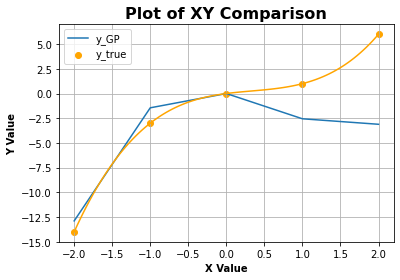

In [10]:
q_y = 3
y_GP_input = np.zeros((n,3))
for j in range(n):
    y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])

y_GP_Opt = create_y_data(q_y,y_GP_input)

title = "XY Comparison"
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)